# Вариационные автоэнкодеры (VAE)

Мотивация:

Хотим вместо представления слева получить представление справа, чтобы зоны пересечения содержали действительно переходные картины:



<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/latent_space_with_and_witout_regularization.png" width="850"></center>


Постановка задачи с автоэнкодером говорит нам, что существует некое пространство меньшей размерности $Z$, которое и обуславливает процесс генерации объектов из $X$. Все остальные различия — следствия случайности: один и тот же человек может по-разному написать цифру $5$.

Будем искать латентное пространство $Z$, которое удовлетворяет следующему условию:

$$\large p(x) = \int p(x, z)dz $$

Кроме того, пусть объекты из $Z$ легко генерировать.

По формуле совместной вероятности:

$$\large p(x, z) = p(x|z)p(z) $$

Осталось только подобрать такие параметры, чтобы все работало.

К сожалению, сделать это в таком виде не получится. Пространство $X$ может быть высокоразмерным.

Но мы можем существенно сузить область поиска, ведь каждому $x$ из пространства $X$ соответствует лишь небольшая возможная область в $Z$.

Для этого будем также учить отображение из пространства $X$ в пространство $Z$, т. е. пытаться выучить $q(z|x)$.

Что же в случае автоэнкодера выполняет роль $q(z|x)$ и $p(x|z)$?
Очевидно, кодировщик и декодировщик соответственно.


<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/vae_as_two_functions.png" width="500"></center>


Чтобы все получилось, нужно сделать с кодировщиком две вещи. Заметьте, что декодировщик мы оставим без изменений.

## Семплирование в латентном пространстве

Пусть наш кодировщик генерирует на основе объекта $X$ вектор средних и вектор стандартных отклонений.

Этих двух векторов хватает нам для того, чтобы задать многомерное нормальное распределение с независимыми компонентами (чтобы матрица ковариаций была диагональной), соответствующее данному объекту.

Чтобы получить латентное представление объекта, отличающегося от $X$ только в силу случайности, нам достаточно семплировать вектор из нормального распределения с такими параметрами.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/vae_architecture_first_modification.png" width="800"></center>

Далее мы можем требовать, чтобы из полученного латентного представления декодировщик восстанавливал объект, похожий на исходный.

Энкодер обычного AE всегда отображает конкретный входной объект в одну и ту же точку в латентном пространстве.

Семплирование в латентном пространстве — ключевое отличие вариационного автоэнкодера от обычного.

Вместо предсказания координат точки в латентном пространстве для конкретного входного объекта энкодер VAE предсказывает параметры многомерного нормального распределения. Далее происходит семплирование точки из этого распределения с параметрами, предсказанными энкодером.

Благодаря этому декодер получает на вход более вариативные данные, включающие точки из областей латентного пространства, которые обычный автоэнкодер оставлял пустыми. Это позволяет декодеру обучаться генерировать более разнообразные объекты. При этом при многократном запуске VAE для одного и того же входного объекта будут генерироваться немного отличающиеся выходные объекты.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/ae_vs_vae.png" width="1000"></center>

<font size="4">Репараметризация</font>

Здесь, однако, сразу возникает проблема с тем, что граф вычислений, соответствующий предыдущей структуре, не может пропускать градиент — как пропустить градиент через генератор случайного нормального числа? Если считать из определения, то даже малейшему изменению параметра могут соответствовать бесконечные изменения генерируемого числа (нормальное распределение определено на бесконечности).

Но мы можем вспомнить замечательное свойство нормального распределения:

$$\large N(\mu,\sigma^2) = N(0,1) * \sigma + \mu$$

Выполняется это и для многомерного случая. Поэтому сделаем следующее: будем генерировать вектор $\varepsilon \sim N(0, 1)$ из стандартного нормального распределения, а затем домножать его на вектор стандартных отклонений и прибавлять вектор средних. Получится вот такое преобразование, которое называется **reparameterization trick**.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/reparametrization_trick.png" width="850"></center>



В отличие от левого случая, в правом мы спокойно можем пропустить градиент через детерминистичные ноды.


Но такой принцип также имеет проблему предыдущего детерминистического подхода, так как вероятностное распределение сможет свернуться в дельта-функцию — зачем нейросети мучиться с объектами, немного отличающимися от тех, что есть в обучающей выборке, и пытаться нормально их восстанавливать, если можно просто начать генерировать стандартные отклонения, близкие к нулю, и тем самым получить $\delta$-функцию, которая будет нашему объекту всегда сопоставлять одну точку в латентном представлении.


<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/sigma_decreasing_progress.gif" width="500"></center>


## Регуляризация латентного пространства

Поэтому нам надо ввести регуляризацию, требующую от каждого распределения быть близким к нормальному распределению вокруг нуля координат латентного пространства с дисперсией $1$ (наше $P(z)$).

Для этого нам нужна некая мера расстояния между двумя вероятностными распределениями. В базовом случае в качестве такой меры расстояния используется **дивергенция Кульбака-Лейблера**, или KL-дивергенция.

[Дивергенция Кульбака-Лейблера 📚[wiki]](https://ru.wikipedia.org/wiki/Расстояние_Кульбака_—_Лейблера) между двумя вероятностными распределениями $P$ и $Q$ определяется следующим образом:

$$\large KL(P||Q) = \int_X p(x)\log \dfrac {p(x)} {q(x)} dx$$

В теории информации $p$ считается целевым (истинным) распределением, а $q$ — тем, с которым мы его сравниваем (проверяемым).

Чтобы распределение $Q(z|x)$ в латентном пространстве $Z$ походило на нормальное, в качестве регуляризации мы будем использовать KL-дивергенцию между $Q(z|x)$ и стандартным нормальным распределением $N(0,1)$.


$$\large \text{Regularization} = KL(Q(z|x)||N(0,1)) $$

Данное выражение может быть [записано аналитически ✏️[blog]](https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes):


$$\large KL(N(\mu, \sigma) || N(0, 1)) = -\frac {1} {2}(\log {\sigma^2} - \sigma^2 - \mu^2 + 1)$$


<center><img src="https://ml.gan4x4.ru/msu/dep-2.1/L12/pure_kl_loss.png" width="350"></center>

<center><em>Source: <a href="https://www.jeremyjordan.me/variational-autoencoders/">Variational Autoencoders</a></em></center>

Однако нужно не забыть, что на выходе мы все еще ожидаем получить изображение, похожее на входное. Поэтому итоговая функция потерь будет состоять из двух компонент:

1. Слагаемое, связанное с качеством восстановления.
2. Регуляризационный член.

Формально это записывается следующим образом:

$$\large \text{VAE Loss} = E_{z \sim Q(z|x)}[\log P(x|z)] + KL[Q(z|x)||N(0,1)]$$

А в итоге:

$$\large \text{VAE Loss} = \text{MSE}(x , \tilde{x}) -\frac {1} {2}(\log {\sigma^2} - \sigma^2 - \mu^2 + 1)$$



Учет обеих компонент позволяет нам получить то, что мы хотели, — регулярное латентное пространство, где нет «дыр» в представлении и при этом близкие по смыслу объекты расположены рядом, а далекие — далеко.

## Реализация VAE

Для реализации вариационного автоэнкодера нам потребуется переопределить логику того, как данные проходят через модель. Выход энкодера будет интерпретироваться не как латентное представление входного образа, а как параметры распределения, из которого мы будем семплировать латентные представления для подачи в декодер.

Вариационный энкодер фактически ничем не будет отличаться от базового за исключением того, что размерность выхода должна быть четной — для разделения на $μ$ и $\sigma$.

In [ ]:
import torch.nn as nn


class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [32, 64, 128, 256]  # num of filters in layers
        modules = []
        in_channels = 1  # initial value of channels
        for h_dim in hidden_dims:  # conv layers
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,  # num of input channels
                        out_channels=h_dim,  # num of output channels
                        kernel_size=3,
                        stride=2,  # convolution kernel step
                        padding=1,  # save shape
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim  # changing number of input channels for next iteration

        modules.append(nn.Flatten())  # to vector, size 256 * 2 * 2 = 1024
        modules.append(nn.Linear(256 * 2 * 2, latent_dim))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [256, 128, 64, 32]  # num of filters in layers
        self.linear = nn.Linear(in_features=latent_dim, out_features=1024)

        modules = []
        for i in range(len(hidden_dims) - 1):  # define upsample layers
            modules.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(
                        in_channels=hidden_dims[i],
                        out_channels=hidden_dims[i + 1],
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels=hidden_dims[-1], out_channels=1, kernel_size=5),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x)  # from latents space to Linear
        x = x.view(-1, 256, 2, 2)  # reshape
        x = self.decoder(x)  # reconstruction
        return x

In [ ]:
class VAEEncoder(Encoder):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0:  # check for the parity of the latent space
            raise Exception("Latent size for VAEEncoder must be even")

        super().__init__(latent_dim)

Для реализации VAE также воспользуемся фреймворком Lightning. Класс `LitVAE` унаследуем от базового `LitAE`, изменив логику прохождения данных через модель (переопределяется `forward_handler`) и расчет функции потерь (переопределяется `loss_handler`):

* Во время прохода данных через автоэнкодер они сначала кодируются в латентное представление с помощью энкодера:
  
  `latent = self.encoder(data)`

  Затем латентное представление разделяется на две части $\mu$ и $\sigma$:

  `mu, log_var = self.vae_split(latent)`

  Производится репараметризация — семплирование из нормального распределения с параметрами, предсказанными энкодером:

  `sample = self.vae_reparametrize(mu, log_var)`
  
  И наконец декодер восстанавливает данные из результата семплирования:

  `recon = self.decoder(sample)`

* Функция потерь теперь содержит две компоненты:
    
 *   штраф за некачественное восстановление в виде бинарной кросс-энтропии между входными данными и восстановленными на выходе декодера данными:

    `F.mse_loss(recon, data)`

 *   и штраф за отличие латентного представления после репараметризации от стандартного нормального распределения в виде KL-дивергенции:

    `kld_loss(mu, log_var)`.

  Эти компоненты суммируются в функции потерь с весами `recon_weight` и `kld_weight`

Методы `vae_split`, `vae_reparametrize` и `kld_loss` обслуживают описанную логику работы VAE.

In [ ]:
!pip install -q lightning tbparse

In [ ]:
import lightning as L
import torch.nn.functional as F
from collections import defaultdict
import torch


class LitAE(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward_handler(self, data, *args, **kwargs):
        # here is the logic how data is moved through AE
        latent = self.encoder(data)
        recon = self.decoder(latent)
        return latent, recon

    def loss_handler(self, recon, data, *args, **kwargs):
        # here is the loss function computing
        loss = F.mse_loss(F.sigmoid(recon), data)
        return loss

    def training_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        loss = self.loss_handler(recon, data, latent)

        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        loss = self.loss_handler(recon, data, latent)

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_start(self):
        # create dict with empty tensors for further accumulating over batches
        self.test_result = defaultdict(torch.Tensor)

    def test_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        self.update_test_result(data, F.sigmoid(recon), latent, labels)

    def update_test_result(self, data, recon, latent, labels):
        # accumulating results every batch
        self.test_result["real"] = torch.cat([self.test_result["real"], data.cpu()])
        self.test_result["recon"] = torch.cat([self.test_result["recon"], recon.cpu()])
        self.test_result["latent"] = torch.cat(
            [self.test_result["latent"], latent.cpu()]
        )
        self.test_result["labels"] = torch.cat(
            [self.test_result["labels"], labels.cpu()]
        )

    def on_test_epoch_end(self):
        # simply change type from torch tensor to numpy array
        # for every item in test_result dictionary
        for key in self.test_result:
            self.test_result[key] = self.test_result[key].numpy()

Загрузим и подготовим датасет MNIST:

In [ ]:
import torchvision
from torchvision.datasets import MNIST
from IPython.display import clear_output

root = "./data"

train_set = MNIST(
    root=root, train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_set = MNIST(
    root=root, train=False, transform=torchvision.transforms.ToTensor(), download=True
)


In [ ]:
import torch
from torch.utils.data import random_split

torch.manual_seed(42)
train_set, val_set = random_split(train_set, lengths=[50000, 10000])

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=2
)

In [ ]:
import lightning as L
import torch.nn.functional as F


class LitVAE(LitAE):
    def __init__(self, encoder, decoder, kld_weight=0.005, recon_weight=1.0):
        super().__init__(encoder, decoder)
        self.kld_weight = kld_weight
        self.recon_weight = recon_weight

    def vae_split(self, latent):
        size = (
            latent.shape[1] // 2
        )  # divide the latent representation into mu and log_var
        mu = latent[:, :size]
        log_var = latent[:, size:]
        return mu, log_var

    def vae_reparametrize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn(mu.shape[0], mu.shape[1]).to(self.device)
        return eps * sigma + mu

    def kld_loss(self, mu, log_var):
        var = log_var.exp()
        kl_loss = torch.mean(-0.5 * torch.sum(log_var - var - mu**2 + 1, dim=1), dim=0)
        return kl_loss

    def forward_handler(self, data, *args, **kwargs):
        # here is the logic how data is moved through AE
        latent = self.encoder(data)

        mu, log_var = self.vae_split(latent)
        sample = self.vae_reparametrize(mu, log_var)

        recon = self.decoder(sample)
        return latent, recon

    def loss_handler(self, recon, data, latent, *args, **kwargs):
        mu, log_var = self.vae_split(latent)
        # here is the loss function computing
        loss = self.recon_weight * F.mse_loss(
            F.sigmoid(recon), data
        ) + self.kld_weight * self.kld_loss(mu, log_var)
        return loss

### Демонстрация эффекта регуляризации

Для демонстрации того, как работает регуляризация в виде KL-дивергенции, обучим VAE, полностью отключив штраф за качество восстановления (`recon_weight=0`).

Видим, что мы забываем про декодировщик — он может выдавать все, что угодно. Потому логично ожидать, что обучится только кодировщик, и обучится он отражать наши точки в нормальное распределение со средним 0 и дисперсией 1. Можем проверить это.

In [ ]:
!mkdir lightning_logs/VAE_latent_dim=2_KL_only

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger
L.seed_everything(42)

latent_dim = 2
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

autoencoder = LitVAE(encoder, decoder, kld_weight=0.1, recon_weight=0.0)  # bad practice

exp_name = f"VAE_latent_dim={latent_dim}_KL_only"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

Протестируем обученный VAE и рассмотрим генерируемые им параметры распределения $\mu$ и $\sigma$.

In [ ]:
import numpy as np
trainer.test(autoencoder, test_loader)
run_res = autoencoder.test_result

mu, log_var = autoencoder.vae_split(run_res["latent"])
var = np.exp(log_var)

Все генерируемые средние почти неотличимы от нуля, а дисперсии — от единицы:

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(mu.ravel())
plt.xlabel("$\mu$", fontsize=20)

plt.subplot(1, 2, 2)
plt.hist(var.ravel())
plt.xlabel("$\sigma^2$", fontsize=20)

plt.show()

В результате получаем практически неразделимые объекты:

In [ ]:
def plot_manifold(latent_r, labels=None, alpha=0.9, title=None):
    plt.figure(figsize=(10, 8))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], alpha=alpha, s=4)
    else:
        plt.scatter(
            latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha, s=4
        )
        plt.colorbar()

    if title:
        plt.title(title)
    plt.show()

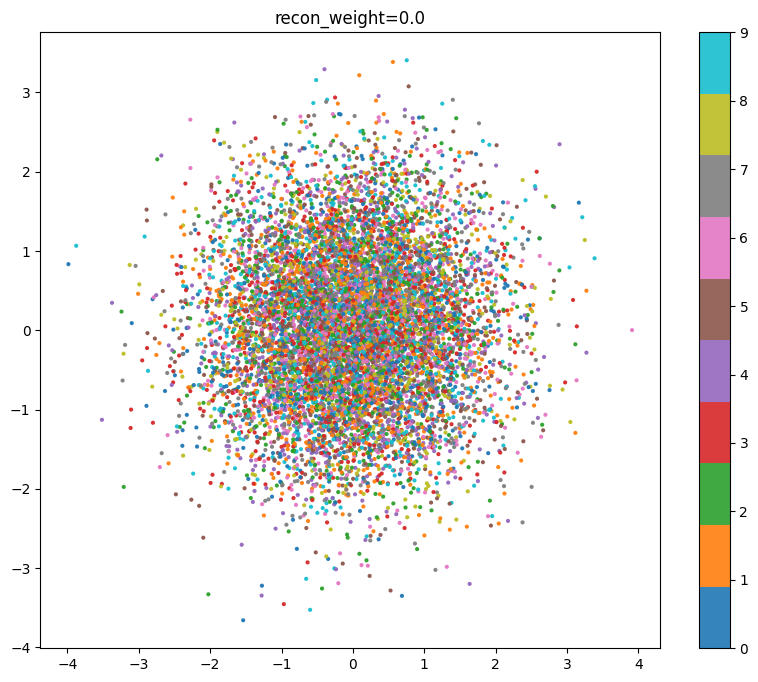

In [73]:
import seaborn as sns

mu, log_var = torch.tensor(mu), torch.tensor(log_var)
sample = autoencoder.vae_reparametrize(mu, log_var).numpy()

pal = sns.color_palette("Paired", n_colors=10)
plot_manifold(
    sample, run_res["labels"], title=f"recon_weight={autoencoder.recon_weight}"
)

### Совмещение ошибки восстановления и KL-дивергенции

Обучим VAE, штрафуя его и за качество восстановления (` recon_weight=1.0`), и за отличие распределения латентных представлений от стандартного нормального (`kld_weight=0.005`):

In [74]:
!mkdir lightning_logs/VAE_latent_dim=2

mkdir: cannot create directory ‘lightning_logs/VAE_latent_dim=2’: File exists


In [ ]:
L.seed_everything(42)

latent_dim = 2
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

autoencoder = LitVAE(encoder, decoder, kld_weight=0.005, recon_weight=1.0)

exp_name = f"VAE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | VAEEncoder | 392 K  | train
1 | decoder | Decoder    | 391 K  | train
-----------------------------------------------
784 K     Trainable params
0         Non-trainable params
784 K     Total params
3.138     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
----------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.test(autoencoder, test_loader)
run_res = autoencoder.test_result

mu, log_var = autoencoder.vae_split(run_res["latent"])

mu, log_var = torch.tensor(mu), torch.tensor(log_var)
sample = autoencoder.vae_reparametrize(mu, log_var).numpy()

In [ ]:
pal = sns.color_palette("Paired", n_colors=10)
plot_manifold(
    sample,
    run_res["labels"],
    title=f"kld_weight={autoencoder.kld_weight}, recon_weight={autoencoder.recon_weight}",
)

Картина в латентном пространстве мало чем отличается от той, что мы получали в обычном автоэнкодере. Это от того, что мы пропустили каждый образец тестовой выборки через автоэнкодер всего один раз и каждое изображение отобразилось в одну конкретную точку. Эффект от вариативности VAE можно заметить на множестве запусков, тогда при каждом запуске каждое изображение будет отображаться в близкие, но различные точки в латентном пространстве.

Посмотрим на этот эффект на 10 запусках VAE на тестовой выборке:

In [ ]:
import numpy as np


total_samples, total_labels = [], []

for _ in range(10):
    # process test data with VAE
    trainer.test(autoencoder, test_loader)
    run_res = autoencoder.test_result

    # do vae_split and vae_reparametrize
    mu, log_var = autoencoder.vae_split(run_res["latent"])
    mu, log_var = torch.tensor(mu), torch.tensor(log_var)
    sample = autoencoder.vae_reparametrize(mu, log_var).numpy()

    # accumulate results over several runs
    total_samples.append(sample)
    total_labels.append(run_res["labels"])

total_samples = np.vstack(total_samples)
total_labels = np.vstack(total_labels)
clear_output()

In [ ]:
plot_manifold(
    total_samples,
    total_labels.flatten(),
    alpha=0.5,
    title="VAE latent space after reparametrization",
)

Видим, что цифры разделились в пространстве, но при этом жмутся друг к другу. При этом, что интересно, 4 и 9 почти неотличимы. Это можно объяснить тем, что двух компонент недостаточно, чтобы разделить настолько похожие цифры (по сути, все отличие в заполненности области между двумя рожками 4).

## Плавная интерполяция

Можем "погулять" по латентному пространству и посмотреть на генерируемые из него изображения. Если мы используем размерность латентного пространства 2, мы можем взять точки в узлах равномерной сетки по двум латентным координатам и подать их в декодер.


In [ ]:
steps = 20  # number of images in a row
space1 = torch.linspace(2, -2, steps)
space2 = torch.linspace(-2, 2, steps)
grid = torch.cartesian_prod(space1, space2)
grid[:, [0, 1]] = grid[:, [1, 0]]

plt.figure(figsize=(10, 8))
plt.scatter(
    total_samples[:, 0],
    total_samples[:, 1],
    c=total_labels.flatten(),
    cmap="tab10",
    alpha=0.5,
    s=3,
)
plt.colorbar()
plt.scatter(grid.numpy()[:, 0], grid.numpy()[:, 1], c="k", s=5)
plt.show()

В итоге получим плавные переходы между цифрами:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_samples(*args, digit_size=28, name=None, single_size=2):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="gray_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()

In [ ]:
with torch.no_grad():
    imgs = F.sigmoid(autoencoder.decoder(grid))
    imgs = imgs.to("cpu").numpy().squeeze()

plot_samples(
    *[imgs[x : x + steps] for x in range(0, steps * steps, steps)], single_size=0.35
)

Посмотрим, как теперь получится интерполировать между теми же цифрами 7 и 6. Для сравнения с результатом, полученным обычным автоэнкодером, возьмем размерность латентного пространства такую же, как у него (24).

In [ ]:
!mkdir lightning_logs/VAE_latent_dim=24

In [ ]:
L.seed_everything(42)

latent_dim = 24
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = Decoder(latent_dim=latent_dim)

autoencoder = LitVAE(encoder, decoder, kld_weight=0.005, recon_weight=1.0)

exp_name = f"VAE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

In [ ]:
seven = (test_set.data[test_set.targets == 7][4:5] / 255).unsqueeze(0)
six = (test_set.data[test_set.targets == 6][7:8] / 255).unsqueeze(0)

latent_space1_mu, _ = autoencoder.vae_split(autoencoder.encoder(seven))
latent_space2_mu, _ = autoencoder.vae_split(autoencoder.encoder(six))

In [ ]:
interp_steps = 10
weight = torch.linspace(0, 1, steps=interp_steps)
interp = torch.lerp(
    latent_space1_mu.repeat(interp_steps, 1),
    latent_space2_mu.repeat(interp_steps, 1),
    weight=weight.view(-1, 1),
)
iterp_imgs = F.sigmoid(autoencoder.decoder(interp))
_, axs = plt.subplots(nrows=1, ncols=interp_steps, figsize=(16, 4))
for step in range(0, interp_steps):
    figure = iterp_imgs[step].cpu().detach().numpy()
    figure = figure.reshape(28, 28)
    ax = axs[step]
    ax.imshow(figure, cmap="gray_r", clim=(0, 1))
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False);

Видим плавную интерполяцию. Посмотрим на примере с видео.

In [ ]:
from PIL import Image

interp_steps = 200
weight = torch.linspace(0, 1, steps=interp_steps)
interp = torch.lerp(
    latent_space1_mu.repeat(interp_steps, 1),
    latent_space2_mu.repeat(interp_steps, 1),
    weight=weight.view(-1, 1),
)
iterp_imgs = F.sigmoid(autoencoder.decoder(interp))


resize_coeff = 10
imgs = np.squeeze(iterp_imgs.cpu().detach().numpy())
size = (imgs.shape[1] * resize_coeff, imgs.shape[2] * resize_coeff)


imgs = [
    Image.fromarray(np.uint8(255 - img * 255)).resize(size).convert("RGB")
    for img in imgs
]
imgs[0].save(
    "vae_img.gif",
    save_all=True,
    append_images=imgs[1:],
    optimize=False,
    duration=40,
    loop=0,
)

In [ ]:
from IPython.display import Image as iImage

iImage(open("vae_img.gif", "rb").read())

Семерка стремится сперва перевестись в девятку, которая затем переходит в шестерку, попутно представляя что-то похожее на восьмерку. Похоже, линия интерполяции теперь в меньшей степени проходит через "пустоты", из которых декодер не умеет восстанавливать что-то похожее на реальные цифры.

Проверим наконец, что вариационный автоэнкодер работает как автоэнкодер и может, к примеру, убирать шум.

In [ ]:
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f"(mean={self.mean}, std={self.std})"

In [ ]:
torch.manual_seed(42)

test_noise_set = MNIST(
    root=root,
    train=False,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(), AddGaussianNoise(0.0, 0.10)]
    ),
    download=True,
)

test_noised_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_noise_set, list(range(64))),
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

In [ ]:
trainer.test(autoencoder, test_noised_loader)
run_res = autoencoder.test_result

plot_samples(run_res["real"][0:9], run_res["recon"][0:9])

Аналогично посмотрим, как он восстанавливает изображения:

In [ ]:
trainer.test(autoencoder, test_loader)
run_res = autoencoder.test_result

plot_samples(run_res["real"][0:9], run_res["recon"][0:9])

Работает, но изображения получаются "размытыми". Это следствие семплирования из нормального распределения.

## Векторная арифметика

В принципе, можно даже в латентном пространстве брать разницу черт написания двух одинаковых цифр, прибавлять к другой цифре, получая в результате цифру, написанную немного по-другому.

Например, у нас есть 1, написанная без наклона, и 1, написанная с наклоном.
И у нас есть 9 без наклона.

Вычитаем из девятки единицу без наклона и прибавляем единицу с наклоном. Если все пройдет хорошо, получим девятку с наклоном.





<center><img src="https://ml.gan4x4.ru/msu/dep-2.1/L12/vector_arithmetic_example.png" width="550"></center>

<center><em>Source: <a href="https://blog.otoro.net/2016/04/01/generating-large-images-from-latent-vectors/#:~:text=First%2C%20let%E2%80%99s%20get,the%20autoencoded%20version">Generating Large Images from Latent Vectors</a></em></center>




Попробуем сделать это сами:

In [ ]:
ones = [i[0] for i in test_set if i[1] == 1]
nines = [i[0] for i in test_set if i[1] == 9]
images_vectors = [
    Image.fromarray(np.uint8(255 - nines[95][0] * 255)).resize((256, 256)),
    Image.fromarray(np.uint8(255 - ones[70][0] * 255)).resize((256, 256)),
    Image.fromarray(np.uint8(255 - ones[0][0] * 255)).resize((256, 256)),
]

In [ ]:
straight_9 = torch.tensor(np.expand_dims(nines[95], axis=0))
straight_1 = torch.tensor(np.expand_dims(ones[70], axis=0))
tilted_1 = torch.tensor(np.expand_dims(ones[0], axis=0))

# latent_9_straight.shape
latent_9_straight, _ = autoencoder.vae_split(autoencoder.encoder(straight_9))
latent_1_straight, _ = autoencoder.vae_split(autoencoder.encoder(straight_1))
latent_1_tilted, _ = autoencoder.vae_split(autoencoder.encoder(tilted_1))

latent_9_tilted = latent_9_straight - latent_1_straight + latent_1_tilted
gen_9_tilted = F.sigmoid(autoencoder.decoder(latent_9_tilted))

images_vectors.append(
    Image.fromarray(
        np.uint8(255 - np.squeeze(gen_9_tilted.cpu().detach().numpy()) * 255)
    ).resize((256, 256))
)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(14, 2))

operators = ["–", "+", "=", ""]
image_index = 0
for i, ax in enumerate(axes):
    if i % 2 == 0:
        ax.imshow(images_vectors[image_index], cmap="gray")
        image_index += 1
    else:
        ax.text(0.5, 0.5, operators[int(i / 2)], fontsize=40, ha="center", va="center")
        ax.axis("off")
    ax.axis("off")
plt.show()

Удалось перенести наклон единицы на девятку. Получилось неплохо, однако простой VAE не гарантирует того, что "фокус удастся". Для получения возможности использовать векторную арифметику могут применяться специальные функции потерь и архитектуры.

## Ограничения VAE

Одна из проблем VAE, с которой можно столкнуться, состоит в том, что две компоненты функции потерь конфликтуют друг с другом. Если будет доминировать KL-loss, то мы получим представление, из которого наши объекты очень плохо восстанавливаются — они раскиданы по представлению, как угодно.

Если же, наоборот, будет доминировать reconstruction loss, то мы получим ситуацию, в которой объекты восстанавливаются нормально, однако в латентном пространстве есть пустоты.

Проблема возникает и с самой KL-дивергенцией, у которой есть ряд существенных недостатков. Есть другие способы оценки близости двух распределений, которые порой дают лучшие результаты. К ним относятся дивергенция Йенсена — Шеннона и метрика Вассерштейна (используется в Wasserstein autoencoders), изучение которых выходит за рамки курса.

Кроме того, в случае, когда декодировщик содержит значительно больше параметров, нежели кодировщик, может возникать ситуация, при которой сгенерированное латентное представление игнорируется.

# Условные вариационные автоэнкодеры (CVAE)

## Реализация CVAE

Как, используя обычный VAE, сгенерировать картинку с заданной меткой?

На самом деле, задача нетривиальна. Как вариант, мы можем понять, в какие области латентного пространства VAE отображает разные цифры, и затем семплировать уже из этих областей.

Хорошо, а если мы хотим нарисовать единицу тем же почерком, которым нарисована данная нам тройка? В этом случае классический VAE вообще не получится использовать.

В случае, если мы имеем априорную информацию, например, разметку изображений по классам, мы можем подавать ее в модель при обучении. Тем самым мы можем *обуславливать* декодировщик на генерацию объекта конкретного класса. Таким образом мы можем получить Conditional VAE (CVAE).

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/cvae_scheme.png" width="850"></center>


Как подмешивать метку к изображению, чтобы передать это полностью свёрточной нейронной сети, не очевидно и обычно не нужно. Часто достаточно передавать метку только декодеру. Энкодер имеет в распоряжении изначальный объект и при желании может предсказать его метку сам.

Напишем код для CVAE. По сути, надо поменять только декодер.

Для кодирования метки класса добавим в декодер слой `label_embedding`, содержащий модуль `nn.Embedding`. Этот модуль будет обучать векторные представления меток классов и переводить их в вектора с размерностью `class_dim`. Размерность этих эмбеддингов в общем случае должна быть сопоставима с размерностью скрытого представления самого автоэнкодера.

Во время работы мы будем конкатенировать латентное представление, полученное после репараметризации выхода энкодера, с векторным представлением метки класса. Для этого требуется изменить количество входов линейного слоя декодера.

In [ ]:
class CDecoder(Decoder):
    def __init__(self, latent_dim, class_dim):
        super().__init__(latent_dim)

        self.label_embedding = nn.Embedding(num_embeddings=10, embedding_dim=class_dim)

        linear_out_features = self.linear.out_features

        # linear will take latent vector concatenated with label embedding
        self.linear = nn.Linear(
            in_features=latent_dim + class_dim,
            out_features=linear_out_features,
        )

    def forward(self, x, label):
        label = self.label_embedding(label)
        x = torch.cat(
            [x, label], dim=1
        )  # concatenate latent vector and label embedding
        x = self.linear(x)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder(x)
        return x

Для описания CVAE потребуется лишь внести изменение в логику прохождения данных через модель (метод `forward_handler`): декодер принимает не только семпл после репараметризации выхода энкодера, но еще и метку класса. Вся остальная логика полностью наследуется от VAE.

In [ ]:
import lightning as L


class LitCVAE(LitVAE):
    def forward_handler(self, data, labels, *args, **kwargs):
        # here is the logic how data is moved through AE
        latent = self.encoder(data)

        mu, log_var = self.vae_split(latent)
        sample = self.vae_reparametrize(mu, log_var)

        # decoder takes latent vector and class label
        recon = self.decoder(sample, labels)
        return latent, recon

In [ ]:
!mkdir lightning_logs/CVAE_latent_dim=2

In [ ]:
L.seed_everything(42)

latent_dim = 2
class_dim = 4
encoder = VAEEncoder(latent_dim=latent_dim * 2)
decoder = CDecoder(latent_dim=latent_dim, class_dim=class_dim)

autoencoder = LitCVAE(encoder, decoder, kld_weight=0.005, recon_weight=1.0)

exp_name = f"CVAE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

In [ ]:
trainer.test(autoencoder, test_loader)
run_res = autoencoder.test_result

plot_samples(run_res["real"][0:9], run_res["recon"][0:9])

Добавив передачу метки в декодер, мы позволили автоэнкодеру отображать все цифры в "одно место". За счет этого ему легче стало учиться.

При этом, если нарисовать латентное представление для всех наших цифр разом, получится комок, сосредоточенный в области нормального распределения. Это не значит, что оно плохое. Просто наша картина не учитывает, что нейросеть различает цифры теперь по меткам, а не по латентному представлению.

In [ ]:
plot_manifold(run_res["latent"], run_res["labels"])

Теперь у каждой цифры "свое" нормальное распределение.

In [ ]:
plot_manifold(run_res["latent"][run_res["labels"] == 4])

In [ ]:
plot_manifold(run_res["latent"][run_res["labels"] == 9])

### Генерация заданных цифр из латентного распределения

Посмотрим, как выглядит наше латентное представление, скажем, для четверок, которых мы до этого почти не видели (сливались с 9).

In [ ]:
steps = 20  # number of images in a row
space1 = torch.linspace(2, -2, steps)
space2 = torch.linspace(-2, 2, steps)
grid = torch.cartesian_prod(space1, space2)
grid[:, [0, 1]] = grid[:, [1, 0]]

label = torch.full((grid.shape[0],), 4)
with torch.no_grad():
    imgs = F.sigmoid(autoencoder.decoder(grid, label))
    imgs = imgs.cpu().numpy().squeeze()

plot_samples(
    *[imgs[x : x + steps] for x in range(0, steps * steps, steps)], single_size=0.35
)

Видим, что четверки плавно расположены по стилю.

In [ ]:
label = torch.full((grid.shape[0],), 9)
with torch.no_grad():
    imgs = F.sigmoid(autoencoder.decoder(grid, label))
    imgs = imgs.cpu().numpy().squeeze()

plot_samples(
    *[imgs[x : x + steps] for x in range(0, steps * steps, steps)], single_size=0.35
)

При желании можно посмотреть на процесс того, как нейросеть учит такие латентные представления.

Ниже показано, как нейросеть выполняет задачу генерации заданной цифры по мере обучения и как выглядит латентное представление объектов, относящихся к данной цифре (для примера взята семерка).

<table><tr>
<td> <img src="https://ml.gan4x4.ru/msu/dep-2.1/L12/gen_cvae_7.gif" style="width: 400px;"/> </td>
<td> <img src="https://ml.gan4x4.ru/msu/dep-2.1/L12/lat_cvae_7.gif" style="width: 400px;"/> </td>
</tr></table>

<center><em>Source: <a href="https://habr.com/ru/articles/331664/">Автоэнкодеры в Keras, Часть 4: Conditional VAE</a></em></center>

### Генерация заданных цифр с переносом стиля

Также успешно такая нейросеть справится в задаче, где мы используем латентное представление одной цифры  для того, чтобы сгенерировать цифру с таким же стилем написания.

Чтобы сделать это, достаточно просто получить латентное представление для 8, а затем передать его в декодер с меткой 3.

<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/generation_indicated_digits_from_latent_space.png" width="800"></center>


Результаты переноса стилей для нескольких разных восьмерок представлены ниже.



<center><img src="https://ml.gan4x4.ru/msu/dev-2.2/L12/out/style_transfer.png" width="500"></center>

Реализуем в коде перенос стиля двойки на другие цифры.

In [ ]:
imgs, labels = next(iter(test_loader))
real = imgs[labels == 2][4:5]

In [ ]:
size = (256, 256)
Image.fromarray(np.uint8(255 - np.squeeze(real.numpy()) * 255)).resize(size)

In [ ]:
torch.manual_seed(42)

sample_size = 10

mu, log_var = autoencoder.vae_split(autoencoder.encoder(real))
sigma = torch.exp(0.5 * log_var)
z = torch.randn(sample_size, mu.shape[1])
latent = z * sigma + mu

label = torch.arange(10)

In [ ]:
with torch.no_grad():
    imgs = F.sigmoid(autoencoder.decoder(latent, label))
    imgs = np.squeeze(imgs.cpu().numpy())

In [ ]:
plot_samples(imgs)